## **Setting up the environment**


In [1]:
# General libraries
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# Graph related libraries
import networkx as nx
from node2vec import Node2Vec

# Machine learning libraries
import gensim
from gensim.models import FastText
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Concatenate, Input, Dropout
from tensorflow.keras.models import Model

2025-09-07 15:35:46.297788: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-07 15:35:46.564045: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-07 15:35:48.118373: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## **Loading the data**

We will load the HatEval dataset. It is a dataset about violence against women and immigrants.

In [2]:
hatEval_df = pd.read_csv("./computed_data/hatEval.csv")

# Lists are loaded as strings. So it is important to get their normal form.
hatEval_df["mentions"] = hatEval_df["mentions"].apply(ast.literal_eval)
hatEval_df["themes"] = hatEval_df["themes"].apply(ast.literal_eval)

In [3]:
hatEval_df.head()

,tweet,tweet_1,tweet_2,mentions,themes,HS,TR,AG
0,"Hurray, saving us $$$ in so many ways @potus @...","Hurray, saving us $$$ in so many ways",hurray save way,"[@potus, @realDonaldTrump]",[],1,0,0
1,Why would young fighting age men be the vast m...,Why would young fighting age men be the vast m...,young fighting age man vast majority escape wa...,[Neil Young],[Europe],1,0,0
2,@KamalaHarris Illegals Dump their Kids at the ...,Illegals Dump their Kids at the border like Ro...,illegal dump kid border like road kill refuse ...,[@KamalaHarris],"[Amnesty International, Fraud]",1,0,0
3,NY Times: 'Nearly All White' States Pose 'an A...,NY Times: 'Nearly All White' States Pose 'an A...,ny time nearly white state pose array problem ...,[],"[U.S., the United States Census, The New York ...",0,0,0
4,Orban in Brussels: European leaders are ignori...,Orban in Brussels: European leaders are ignori...,orban brussels european leader ignore people w...,[Viktor Orbán],"[Brussels, European Union]",0,0,0


In [4]:
hatEval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet     10000 non-null  object
 1   tweet_1   9958 non-null   object
 2   tweet_2   9924 non-null   object
 3   mentions  10000 non-null  object
 4   themes    10000 non-null  object
 5   HS        10000 non-null  int64 
 6   TR        10000 non-null  int64 
 7   AG        10000 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 625.1+ KB


In [5]:
hatEval_df.isna().sum()

tweet        0
tweet_1     42
tweet_2     76
mentions     0
themes       0
HS           0
TR           0
AG           0
dtype: int64

In [6]:
hatEval_df = hatEval_df.dropna()

In [7]:
hatEval_df.shape

(9924, 8)

## **Building the knowledge graph**

In [8]:
def build_knowledge_graph(df): 
    G = nx.Graph()
    co_occurrence = {}  # Dictionary for counting co-occurrences

    for _, row in df.iterrows():
        mentions = row["mentions"]
        themes = row["themes"]

        # Add relationships between personalities (isMentionedWith)
        for i in range(len(mentions)):
            for j in range(i + 1, len(mentions)):
                edge = tuple(sorted([mentions[i], mentions[j]]))
                co_occurrence[edge] = co_occurrence.get(edge, 0) + 1

        # Add relationships between personalities and themes (isLinkedTo)
        for mention in mentions:
            for theme in themes:
                edge = (mention, theme)
                co_occurrence[edge] = co_occurrence.get(edge, 0) + 1

        # Add relationships between themes (isRelatedTo)
        for i in range(len(themes)):
            for j in range(i + 1, len(themes)):
                edge = tuple(sorted([themes[i], themes[j]]))
                co_occurrence[edge] = co_occurrence.get(edge, 0) + 1

    # Add edges to the graph with their weights
    for (node1, node2), weight in co_occurrence.items():
        G.add_edge(node1, node2, weight=weight)

    # Normalize the weights with Min-Max (between 0 and 1)
    weights = [data["weight"] for _, _, data in G.edges(data=True)]
    min_weight = min(weights)
    max_weight = max(weights)
    for u, v, data in G.edges(data=True):
        if max_weight > min_weight:
            data["weight"] = data["weight"]/max_weight
        else:
            data["weight"] = 1.0

    # Add labels to nodes
    for node in G.nodes():
        if any(node in mentions for mentions in df["mentions"]):
            G.nodes[node]["label"] = "Person"
        elif any(node in themes for themes in df["themes"]):
            G.nodes[node]["label"] = "Theme"

    # Add labels to edges
    for u, v, data in G.edges(data=True):
        if G.nodes[u]["label"] == "Person" and G.nodes[v]["label"] == "Person":
            data["relation"] = "isMentionedWith"
        elif G.nodes[u]["label"] == "Theme" and G.nodes[v]["label"] == "Theme":
            data["relation"] = "isRelatedTo"
        else:
            data["relation"] = "isLinkedTo"

    return G

In [9]:
G = build_knowledge_graph(hatEval_df)

In [10]:
sample_nodes = list(G.nodes(data=True))[:5]
sample_nodes

[('@potus', {'label': 'Person'}),
 ('@realDonaldTrump', {'label': 'Person'}),
 ('Neil Young', {'label': 'Person'}),
 ('Europe', {'label': 'Theme'}),
 ('@KamalaHarris', {'label': 'Person'})]

In [11]:
sample_edges = list(G.edges(data=True))[:5]
sample_edges

[('@potus',
  '@realDonaldTrump',
  {'weight': 0.16883116883116883, 'relation': 'isMentionedWith'}),
 ('@potus',
  'George Soros',
  {'weight': 0.012987012987012988, 'relation': 'isMentionedWith'}),
 ('@potus',
  'Donald Trump',
  {'weight': 0.012987012987012988, 'relation': 'isMentionedWith'}),
 ('@potus',
  'Truth',
  {'weight': 0.006493506493506494, 'relation': 'isLinkedTo'}),
 ('@potus',
  'WELL',
  {'weight': 0.006493506493506494, 'relation': 'isLinkedTo'})]

Display of a sample of the graph

In [12]:
sample_nodes = list(G.nodes())[:10]
G_sample = G.subgraph(sample_nodes)

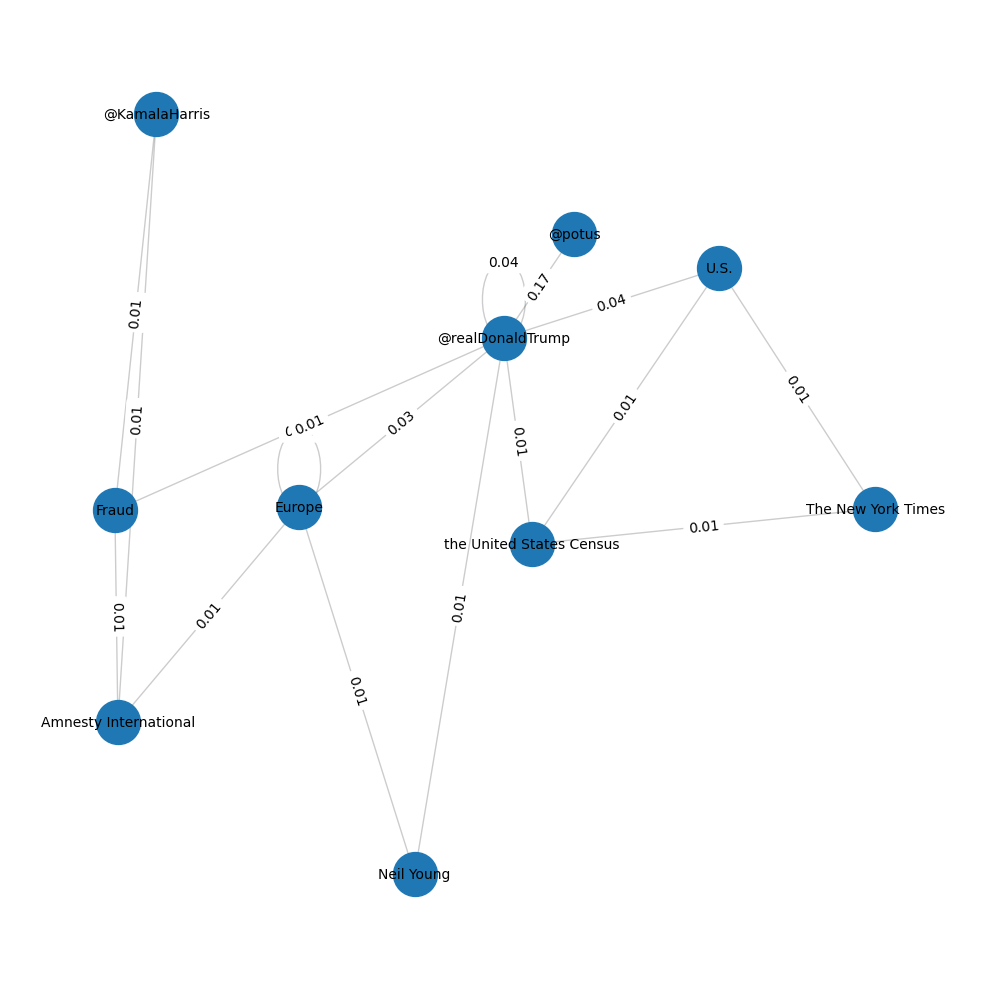

In [13]:
plt.figure(figsize=(10, 10))

elarge = [(u, v) for (u, v, d) in G_sample.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in G_sample.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(G_sample, seed=7)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G_sample, pos, node_size=1000)

# edges
nx.draw_networkx_edges(G_sample, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=1, alpha=0.2, edge_color="black"
)

# node labels
nx.draw_networkx_labels(G_sample, pos, font_size=10, font_family="sans-serif")
# edge weight labels
edge_labels = {edge: f"{weight:.2f}" for edge, weight in nx.get_edge_attributes(G_sample, "weight").items()}

nx.draw_networkx_edge_labels(G_sample, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

## **Split the data**

In [14]:
X = hatEval_df[["tweet_2", "mentions", "themes"]]
y = hatEval_df["HS"]

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [16]:
print(len(y_train), len(y_test))

7939 1985


## **FastText + BiLSTM component**

In [17]:
# Download Fasttext model

import gensim.downloader as api

ft_model = api.load("fasttext-wiki-news-subwords-300")  # About 1 millions of words

In [18]:
%%time

MAX_SEQUENCE_LENGTH = 8  # Ensure 10 words per input / 10
EMBEDDING_DIM = 300       # Each word has a 300-dimensional embedding /300

def get_fasttext_embedding_sequence(text):
    words = text.split()
    vectors = [ft_model[w] for w in words if w in ft_model.key_to_index]
    if not vectors:
        return np.zeros((MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))  # Return zeros if no words are found
    vectors = vectors[:MAX_SEQUENCE_LENGTH]  # Truncate if too long
    return pad_sequences([vectors], maxlen=MAX_SEQUENCE_LENGTH, dtype="float32", padding="post")[0]

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 6.2 μs


In [19]:
X_train["embeddings"] = X_train["tweet_2"].apply(get_fasttext_embedding_sequence)
X_train_embeddings = np.array(X_train["embeddings"].tolist())  # Shape: (num_samples, 10, 300)
y_train_reshaped = np.array(y_train).reshape(-1, 1)

In [20]:
def create_bilstm_model():
    model = Sequential([
        Input(shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)),
        Bidirectional(LSTM(100, return_sequences=True, dropout=0.1)),
        Dropout(0.5),
        tf.keras.layers.GlobalMaxPooling1D(),
        Dense(100, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy",
            tf.keras.metrics.F1Score(average="macro", name="f1_macro")
        ]
    )
    return model

In [21]:
model_ft = create_bilstm_model()
model_ft.fit(X_train_embeddings, y_train_reshaped, epochs=10, batch_size=16, validation_split=0.2)

Epoch 1/10


E0000 00:00:1757252301.461586  143843 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1757252301.476034  143843 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-09-07 15:38:21.605702: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 60969600 exceeds 10% of free system memory.


397/397 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6689 - f1_macro: 0.5932 - loss: 0.6118 - val_accuracy: 0.6921 - val_f1_macro: 0.5966 - val_loss: 0.5976
Epoch 2/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7037 - f1_macro: 0.5932 - loss: 0.5612 - val_accuracy: 0.7091 - val_f1_macro: 0.5966 - val_loss: 0.5822
Epoch 3/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7290 - f1_macro: 0.5932 - loss: 0.5355 - val_accuracy: 0.7179 - val_f1_macro: 0.5966 - val_loss: 0.5736
Epoch 4/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7344 - f1_macro: 0.5932 - loss: 0.5217 - val_accuracy: 0.6732 - val_f1_macro: 0.5966 - val_loss: 0.5995
Epoch 5/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7552 - f1_macro: 0.5932 - loss: 0.5022 - val_accuracy: 0.7084 - val_f1_macro: 0.5966 - val_loss: 0.5650
Epoch 6/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7624 - f1_macro: 0.5932 - loss: 0.4805 - val_accuracy: 0.6870 - val_f1_macro: 0.5966 - val_loss

In [22]:
# Test on test set

X_test_embeddings = np.array(X_test["tweet_2"].apply(get_fasttext_embedding_sequence).tolist())
predictions_ft = model_ft.predict(X_test_embeddings)
predicted_labels_ft = (predictions_ft > 0.5).astype(int) 

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [23]:
print("Precision macro:", precision_score(predicted_labels_ft, y_test, average="macro"))
print("Recall macro:", recall_score(predicted_labels_ft, y_test, average="macro"))
print("F1 macro:", f1_score(predicted_labels_ft, y_test, average="macro"))

Precision macro: 0.6875339424419415
Recall macro: 0.6851617873651772
F1 macro: 0.6743766404199475


## **Node2Vec + BiLSTM component**

In [24]:
G_train = build_knowledge_graph(X_train)

In [25]:
nb_noeuds = G_train.number_of_nodes()
print(f"Nombre de nœuds : {nb_noeuds}")

# Nombre d'arêtes (relations)
nb_aretes = G_train.number_of_edges()
print(f"Nombre d'arêtes : {nb_aretes}")

Nombre de nœuds : 5739
Nombre d'arêtes : 22740


In [26]:
%%time

node2vec = Node2Vec(G_train,
                    dimensions=300,
                    walk_length=5,
                    num_walks=60,
                    workers=8)
nv_model = node2vec.fit(window=5, min_count=3, batch_words=4)

Computing transition probabilities:   0%|          | 0/5739 [00:00<?, ?it/s]

Generating walks (CPU: 8): 100%|██████████| 7/7 [00:01<00:00,  6.50it/s]


CPU times: user 2min 55s, sys: 57.9 s, total: 3min 53s
Wall time: 2min 33s


In [27]:
entities_embeddings = {node: nv_model.wv[node] for node in G_train.nodes()}

def get_entities_embeddings(entities, max_len=8, embedding_dim=300):
  vectors = [entities_embeddings[ent] for ent in entities if ent in entities_embeddings]
  if not vectors:
    vectors = [np.zeros(embedding_dim)]
  vectors = pad_sequences([vectors], maxlen=max_len, dtype="float32", padding="post", truncating="post")
  return vectors[0]

In [28]:
# Combinations of mentions and themes
X_train["entities"] = X_train["mentions"] + X_train["themes"]

# Embeddings of the combinations
X_train["node2vec_embeddings"] = X_train["entities"].apply(lambda ents: get_entities_embeddings(ents))

In [29]:
model_nv = Sequential([
    Input(shape=(10, 300)),
    Dropout(0.5),
    Bidirectional(LSTM(100, return_sequences=True, dropout=0.1)),
    tf.keras.layers.GlobalMaxPooling1D(),
    Dense(100, activation="relu"),
    Dense(1, activation="sigmoid")
])

model_nv.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "accuracy",
        tf.keras.metrics.F1Score(average="macro", name="f1_macro")
    ]
)

X_train_nv = np.stack(X_train["node2vec_embeddings"].tolist())
model_nv.fit(X_train_nv, y_train, epochs=10, batch_size=16, validation_split=0.2)

Epoch 1/10


2025-09-07 15:41:26.819749: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 60969600 exceeds 10% of free system memory.


397/397 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5963 - f1_macro: 0.5932 - loss: 0.6690 - val_accuracy: 0.6033 - val_f1_macro: 0.5966 - val_loss: 0.6566
Epoch 2/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6141 - f1_macro: 0.5932 - loss: 0.6531 - val_accuracy: 0.6159 - val_f1_macro: 0.5966 - val_loss: 0.6531
Epoch 3/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6305 - f1_macro: 0.5932 - loss: 0.6441 - val_accuracy: 0.6253 - val_f1_macro: 0.5966 - val_loss: 0.6480
Epoch 4/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6407 - f1_macro: 0.5932 - loss: 0.6371 - val_accuracy: 0.6146 - val_f1_macro: 0.5966 - val_loss: 0.6484
Epoch 5/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6440 - f1_macro: 0.5932 - loss: 0.6280 - val_accuracy: 0.6184 - val_f1_macro: 0.5966 - val_loss: 0.6466
Epoch 6/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6482 - f1_macro: 0.5932 - loss: 0.6221 - val_accuracy: 0.6278 - val_f1_macro: 0.5966 - val_loss

In [30]:
X_test["node2vec_embeddings"] = X_test["themes"].apply(lambda ents: get_entities_embeddings(ents))
X_test_nv = np.stack(X_test["node2vec_embeddings"].tolist())
predictions_nv = model_nv.predict(X_test_nv)
predicted_labels_nv = (predictions_nv > 0.5).astype(int) 

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [31]:
print("Precision macro:", precision_score(predicted_labels_nv, y_test, average="macro"))
print("Recall macro:", recall_score(predicted_labels_nv, y_test, average="macro"))
print("F1 macro:", f1_score(predicted_labels_nv, y_test, average="macro"))

Precision macro: 0.5328073858753665
Recall macro: 0.5625533113541779
F1 macro: 0.4940627812491365


## **Hybrid model**

In [32]:
# The two inputs of the model (fasttext embeddings + graph embeddings)
input1 = Input(shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))
input2 = Input(shape=(8, 300))

In [33]:
# Extraction of bidirectional LSTM layers
x1 = Bidirectional(LSTM(100, return_sequences=True, dropout=0.1))(input1)
x1 = Dropout(0.5)(x1)

x2 = Bidirectional(LSTM(100, return_sequences=True, dropout=0.1))(input2)
x2 = Dropout(0.5)(x2)

# Concatenation of the two outputs
merged = Concatenate()([x1, x2])

In [34]:
# Global Max Pooling and fully connected layers
x = tf.keras.layers.GlobalMaxPooling1D()(merged)
x = Dense(100, activation="relu")(x)
output = Dense(1, activation="sigmoid")(x)

# Creation of the final model
merged_model = Model(inputs=[input1, input2], outputs=output)

merged_model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy",
            tf.keras.metrics.F1Score(average="macro", name="f1_macro")
        ]
    )

merged_model.fit([X_train_embeddings, X_train_nv], y_train, epochs=10, batch_size=16, validation_split=0.2)

2025-09-07 15:41:57.989013: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 60969600 exceeds 10% of free system memory.
2025-09-07 15:41:58.219532: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 60969600 exceeds 10% of free system memory.


Epoch 1/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 42s 81ms/step - accuracy: 0.6736 - f1_macro: 0.5932 - loss: 0.6048 - val_accuracy: 0.7091 - val_f1_macro: 0.5966 - val_loss: 0.5763
Epoch 2/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7260 - f1_macro: 0.5932 - loss: 0.5438 - val_accuracy: 0.7103 - val_f1_macro: 0.5966 - val_loss: 0.5661
Epoch 3/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7433 - f1_macro: 0.5932 - loss: 0.5142 - val_accuracy: 0.7166 - val_f1_macro: 0.5966 - val_loss: 0.5614
Epoch 4/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7577 - f1_macro: 0.5932 - loss: 0.4927 - val_accuracy: 0.7173 - val_f1_macro: 0.5966 - val_loss: 0.5561
Epoch 5/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7736 - f1_macro: 0.5932 - loss: 0.4709 - val_accuracy: 0.7317 - val_f1_macro: 0.5966 - val_loss: 0.5480
Epoch 6/10
397/397 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7870 - f1_macro: 0.5932 - loss: 0.4446 - val_accuracy: 0.7317 - val_f1_macro:

In [35]:
predictions = merged_model.predict([
    X_test_embeddings,  # Should be shape (batch_size, 10, 300)
    X_test_nv           # Should be shape (batch_size, 10, 128)
])
predicted_labels = (predictions > 0.5).astype(int)

print("Precision macro:", precision_score(predicted_labels, y_test, average="macro"))
print("Recall macro:", recall_score(predicted_labels, y_test, average="macro"))
print("F1 macro:", f1_score(predicted_labels, y_test, average="macro"))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Precision macro: 0.6786995441048871
Recall macro: 0.6908305224845681
F1 macro: 0.6811316573958472


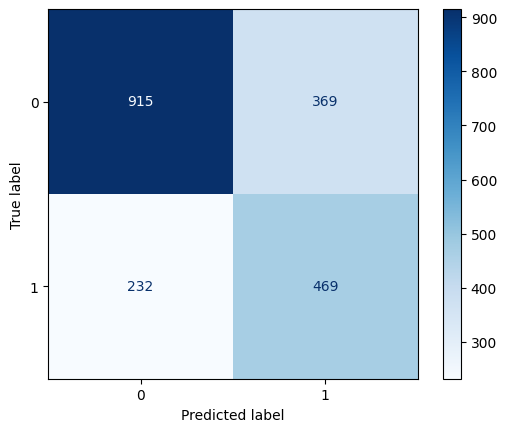

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix(predicted_labels, y_test))
disp.plot(cmap=plt.cm.Blues)
plt.show()

## **Bibliography**

* https://stackoverflow.com/questions/73078231/how-to-get-all-stop-words-from-spacy-and-dont-get-any-errors-typeerror-argume
* https://github.com/eliorc/node2vec
